# Homework 2: Trees and Calibration


## Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

**Make sure to use the dataset that we provide in CourseWorks/Classroom. DO NOT download it from the link provided (It may be different).**

Due Date : 03/02 (2nd March), 11:59 PM EST

## Name: Chandan Suri

## UNI: CS4090

## The Dataset
Credit ([Link](https://www.kaggle.com/gamersclub/brazilian-csgo-plataform-dataset-by-gamers-club?select=tb_lobby_stats_player.csv) | [License](https://creativecommons.org/licenses/by-nc-sa/4.0/))

The goal is to predict wins based on in match performace of multiple players. Please use this dataset and this task for all parts of the assignment.

### Features

idLobbyGame - Categorical (The Lobby ID for the game)

idPlayer - Categorical (The ID of the player)

idRooom - Categorical (The ID of the room)

qtKill - Numerical (Number of kills)

qtAssist - Numerical (Number of Assists)

qtDeath - Numerical (Number of Deaths)

qtHs - Numerical (Number of kills by head shot)

qtBombeDefuse - Numerical (Number of Bombs Defuses)

qtBombePlant - Numerical (Number of Bomb plants)

qtTk - Numerical (Number of Team kills)

qtTkAssist - Numerical Number of team kills assists)

qt1Kill - Numerical (Number of rounds with one kill)

qt2Kill - Numerical (Number of rounds with two kill)

qt3Kill - Numerical (Number of rounds with three kill)

qt4Kill - Numerical (Number of rounds with four kill)

qt5Kill - Numerical (Number of rounds with five kill)

qtPlusKill - Numerical (Number of rounds with more than one kill)

qtFirstKill - Numerical (Number of rounds with first kill)

vlDamage - Numerical (Total match Damage)

qtHits - Numerical (Total match hits)

qtShots - Numerical (Total match shots)

qtLastAlive - Numerical (Number of rounds being last alive)

qtClutchWon - Numerical (Number of total clutchs wons)

qtRoundsPlayed - Numerical (Number of total Rounds Played)

descMapName - Categorical (Map Name - de_mirage, de_inferno, de_dust2, de_vertigo, de_overpass, de_nuke, de_train, de_ancient)

vlLevel - Numerical (GC Level)

qtSurvived - Numerical (Number of rounds survived)

qtTrade - Numerical (Number of trade kills)

qtFlashAssist - Numerical (Number of flashbang assists)

qtHitHeadshot - Numerical (Number of times the player hit headshot

qtHitChest - Numerical (Number of times the player hit chest)

qtHitStomach - Numerical (Number of times the player hit stomach)

qtHitLeftAtm - Numerical (Number of times the player hit left arm)

qtHitRightArm - Numerical (Number of times the player hit right arm)

qtHitLeftLeg - Numerical (Number of times the player hit left leg)

qtHitRightLeg - Numerical (Number of times the player hit right leg)

flWinner - Winner Flag (**Target Variable**).

dtCreatedAt - Date at which this current row was added. (Date)


In [3]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer 
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

## Question 1: Decision Trees

**1.1: Load the provided dataset**

In [4]:
game_data = pd.read_csv("tb_lobby_stats_player.csv")
game_data.head()

,idLobbyGame,idPlayer,idRoom,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qtTk,qtTkAssist,qt1Kill,qt2Kill,qt3Kill,qt4Kill,qt5Kill,qtPlusKill,qtFirstKill,vlDamage,qtHits,qtShots,qtLastAlive,qtClutchWon,qtRoundsPlayed,descMapName,vlLevel,qtSurvived,qtTrade,qtFlashAssist,qtHitHeadshot,qtHitChest,qtHitStomach,qtHitLeftAtm,qtHitRightArm,qtHitLeftLeg,qtHitRightLeg,flWinner,dtCreatedAt
0,1,1,1,5,1,16,2,0,0,0.0,0.0,3,1,0,0,0,0,1,911,25.0,212,0.0,0,17,de_mirage,10,1.0,2.0,0.0,3.0,13.0,4.0,2.0,2.0,1.0,0.0,0,2022-01-21 19:45:44
1,2,1,2,24,3,18,6,0,4,0.0,1.0,9,4,1,1,0,0,3,2933,54.0,597,1.0,1,27,de_nuke,9,8.0,1.0,0.0,7.0,26.0,14.0,2.0,1.0,1.0,3.0,1,2022-02-04 02:09:47
2,3,2,3,6,4,23,2,0,1,0.0,1.0,4,1,0,0,0,0,2,1117,31.0,207,0.0,0,25,de_mirage,2,2.0,3.0,0.0,3.0,15.0,8.0,1.0,2.0,0.0,2.0,0,2021-09-18 18:07:43
3,3,391,27508,10,5,20,4,1,0,0.0,0.0,6,2,0,0,0,0,1,1740,63.0,411,1.0,1,25,de_mirage,15,3.0,4.0,0.0,6.0,27.0,10.0,1.0,7.0,6.0,6.0,1,2021-09-18 18:07:43
4,4,2,4,8,4,26,6,0,2,0.0,0.0,4,2,0,0,0,0,1,1696,51.0,324,0.0,0,30,de_nuke,2,4.0,4.0,2.0,8.0,19.0,12.0,2.0,3.0,2.0,5.0,0,2021-09-27 00:17:45


In [5]:
original_num_rows_in_game_data = len(game_data)
print(f"Number of rows in the dataset: {original_num_rows_in_game_data}")

Number of rows in the dataset: 184152


**1.2: Plot % of missing values in each column. Would you consider dropping any columns? Assuming we want to train a decision tree, would you consider imputing the missing values? If not, why? (Remove the columns that you consider dropping - you must remove the dtCreatedAt column)**

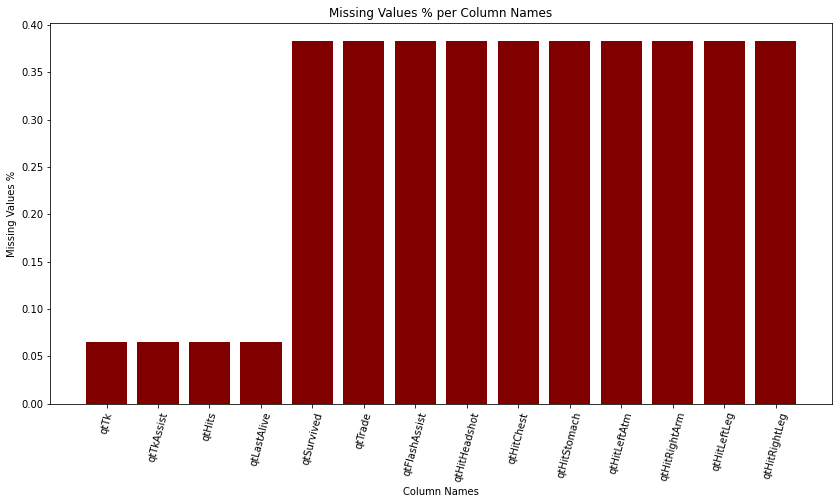

In [6]:
# Analyzing missing values data

'''
Returns the percentages of missing values in each of the columns in the dataset.
'''
def get_missing_value_percentages(data_df):
    col_missing_vals_percent_map = dict()
    num_rows = len(data_df)

    for col in data_df.columns:
        num_missing_vals_in_col = data_df[col].isnull().sum()
        if num_missing_vals_in_col > 0:
            col_missing_vals_percent_map[col] = (num_missing_vals_in_col/num_rows)*100.0
        
    return col_missing_vals_percent_map

'''
Plots a bar chart for the missing values percentage present in the dataset.
'''
def plot_percent_missing_vals(col_missing_vals_percent_map):
    fig = plt.figure(figsize = (14, 7))
    column_names = list(col_missing_vals_percent_map.keys())
    percent_missing_vals = list(col_missing_vals_percent_map.values())
    plt.bar(column_names, percent_missing_vals, color ='maroon')
 
    plt.xlabel("Column Names")
    plt.ylabel("Missing Values %")
    plt.title("Missing Values % per Column Names")
    plt.xticks(rotation = 75)
    plt.show()
    
col_missing_vals_percent_map = get_missing_value_percentages(game_data)
plot_percent_missing_vals(col_missing_vals_percent_map)

Dropping Columns:
1. I will only be discarding the ID columns like "idLobbyGame", "idPlayer", "idRoom" and "dtCreatedAt" column as the ID columns have a lot of unique values and thus, wouldn't contribute much to the ML algorithm being trained. Also, these are ID columns for the data and shouldn't be trained on ideally for our use case here. Also, we drop the "dtCreatedAt" column as that's the date of the game and wouldn't contribute much to ML training.
2. Other than the columns above, I haven't dropped any other columns with missing values. The main reason for this being that the percentage of missing values in any of those columns is at most (approximately 0.38%) which is really less data considering the number of rows (184152) and discarding the columns with missing values would mean a much bigger data loss than imputing/discarding the rows with missing values. Thus, I have chosen to rather keep the columns with missing values.

In [7]:
# Remove Columns

# Remove dtCreated Column by default (most probably because it won't affect the target much,
# because of no/significant corelation)
game_data.drop(["dtCreatedAt"], inplace = True, axis = 1)

In [8]:
categorical_features = ["idLobbyGame", "idPlayer", "idRoom", "descMapName"]
categories_count_map = dict()
for categorical_feature in categorical_features:
    categories_count = game_data[categorical_feature].nunique()
    categories_count_map[categorical_feature] = categories_count

for feature_name, categories_num in categories_count_map.items():
    print(f"{feature_name} : {categories_num}")

idLobbyGame : 172911
idPlayer : 2469
idRoom : 178500
descMapName : 8


In [9]:
categorical_features_to_drop = ["idLobbyGame", "idPlayer", "idRoom"]
game_data.drop(categorical_features_to_drop, inplace = True, axis = 1)

In [10]:
game_data.dropna(subset = list(col_missing_vals_percent_map.keys()), how="any", inplace=True)

In [11]:
# Looking at the data after removing the columns
game_data

,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qtTk,qtTkAssist,qt1Kill,qt2Kill,qt3Kill,qt4Kill,qt5Kill,qtPlusKill,qtFirstKill,vlDamage,qtHits,qtShots,qtLastAlive,qtClutchWon,qtRoundsPlayed,descMapName,vlLevel,qtSurvived,qtTrade,qtFlashAssist,qtHitHeadshot,qtHitChest,qtHitStomach,qtHitLeftAtm,qtHitRightArm,qtHitLeftLeg,qtHitRightLeg,flWinner
0,5,1,16,2,0,0,0.0,0.0,3,1,0,0,0,0,1,911,25.0,212,0.0,0,17,de_mirage,10,1.0,2.0,0.0,3.0,13.0,4.0,2.0,2.0,1.0,0.0,0
1,24,3,18,6,0,4,0.0,1.0,9,4,1,1,0,0,3,2933,54.0,597,1.0,1,27,de_nuke,9,8.0,1.0,0.0,7.0,26.0,14.0,2.0,1.0,1.0,3.0,1
2,6,4,23,2,0,1,0.0,1.0,4,1,0,0,0,0,2,1117,31.0,207,0.0,0,25,de_mirage,2,2.0,3.0,0.0,3.0,15.0,8.0,1.0,2.0,0.0,2.0,0
3,10,5,20,4,1,0,0.0,0.0,6,2,0,0,0,0,1,1740,63.0,411,1.0,1,25,de_mirage,15,3.0,4.0,0.0,6.0,27.0,10.0,1.0,7.0,6.0,6.0,1
4,8,4,26,6,0,2,0.0,0.0,4,2,0,0,0,0,1,1696,51.0,324,0.0,0,30,de_nuke,2,4.0,4.0,2.0,8.0,19.0,12.0,2.0,3.0,2.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184147,21,3,13,5,1,1,0.0,0.0,8,5,1,0,0,0,3,2610,88.0,524,1.0,0,26,de_vertigo,9,11.0,0.0,0.0,7.0,42.0,26.0,1.0,4.0,6.0,2.0,1
184148,15,1,22,5,0,1,0.0,0.0,11,2,0,0,0,0,5,2154,63.0,357,0.0,0,29,de_nuke,9,7.0,5.0,0.0,5.0,21.0,21.0,3.0,7.0,2.0,4.0,1
184149,9,6,23,2,0,3,0.0,0.0,9,0,0,0,0,0,2,1701,59.0,371,0.0,0,27,de_vertigo,9,4.0,2.0,0.0,3.0,25.0,12.0,1.0,5.0,6.0,7.0,0
184150,15,5,20,6,0,2,0.0,0.0,13,1,0,0,0,0,1,2246,65.0,355,0.0,0,25,de_dust2,9,5.0,3.0,1.0,8.0,22.0,16.0,2.0,8.0,3.0,6.0,0


In [12]:
num_rows_removed = original_num_rows_in_game_data - len(game_data)
print(f"Number of rows that had to be removed because of any missing values: {num_rows_removed}")
print(f"Percentage of rows removed that had missing values: {num_rows_removed*100/original_num_rows_in_game_data}")

Number of rows that had to be removed because of any missing values: 705
Percentage of rows removed that had missing values: 0.38283591815456797


As we can see above, I have decided to remove the rows with any missing values rather than imputing those values in the data that are missing. This decision is based on the fact that the percentage of rows removed (0.38%) is really less in comparison to the number of rows that we have in our dataset. Imputing our dataset just because of these small number of rows could rather introduce some imbalances in our dataset rather than help much. If the number of rows with missing values were quite high such that rmeoving those rows would be a huge/moderate data loss, then, I would have just imputed those values. However, that's not the case here, so, I have decided to remove those rows with missing values rather than impute the values for the missing data in the original game data provided.

**1.3: Plot side-by-siide bars of class distribtuion for each category for the categorical feature and the target categories.**

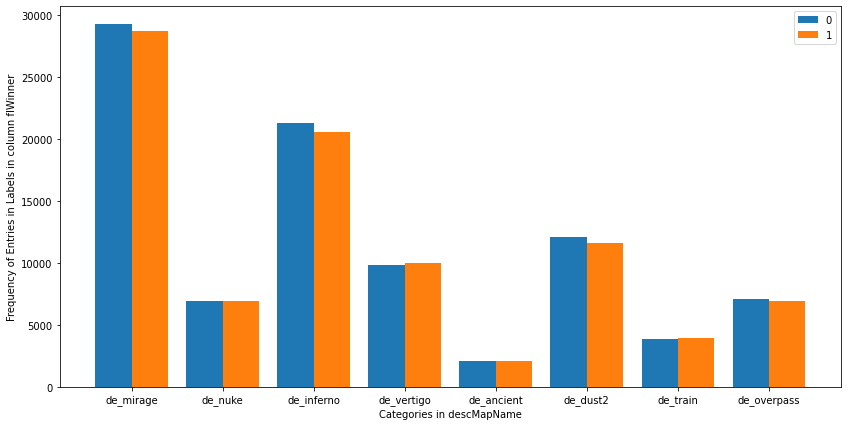

In [13]:
# Getting columns in different buckets
categorical_feature = "descMapName"
target_feature_name = "flWinner"
numerical_features = list(set(game_data.columns) - set([categorical_feature, target_feature_name]))

# As first 3 categorical features above are IDs, we only consider the "descMapName" here to visualize
data_per_category_label = game_data[[categorical_feature, target_feature_name]].value_counts()
categories_in_feature = list(game_data[categorical_feature].unique())
categories_in_label = list(game_data[target_feature_name].unique())

def plot_chart_distribution(data_per_category_label, categories_in_feature, categories_in_label):
    x_axis_data = np.arange(len(categories_in_feature))
    labels_data = defaultdict(list)
    
    for category in categories_in_feature:
        for label in categories_in_label:
            if label not in labels_data:
                labels_data[label] = list()
            labels_data[label].append(data_per_category_label[category][label])
    
    fig = plt.figure(figsize = (14, 7))
    sign = -1
    for label, label_data in labels_data.items():
        plt.bar(x_axis_data + sign * 0.2, labels_data[label], width = 0.4, label = label)
        sign *= -1
        
    plt.xticks(x_axis_data, categories_in_feature)
    plt.xlabel(f"Categories in {categorical_feature}")
    plt.ylabel(f"Frequency of Entries in Labels in column {target_feature_name}")
    plt.legend()
    plt.show()

plot_chart_distribution(data_per_category_label, categories_in_feature, categories_in_label)

**1.4: Split the data into development and test datasets. Which splitting methodology did you choose and why?**

In [14]:
# Firstly I separate the labels from the feature wise data
labels_data = game_data[target_feature_name]
X_data = game_data.drop([target_feature_name], axis = 1)

In [15]:
# Analyzing the labels frequency
game_data[target_feature_name].value_counts()

0    92586
1    90861
Name: flWinner, dtype: int64

In [16]:
# Now I split the data using random splitting
X_dev, X_test, y_dev, y_test = train_test_split(X_data, labels_data, test_size = 0.2)

As we can see above, I have employed "Random splitting" methodology here. This is due to the fact that the number of rows for each of the labels (flWinner) is quite well balanced in our dataset (As shown above). Also, the data is quite well balanced w.r.t the categorical variables in our dataset. In case it wasn't balanced well w.r.t the labels, we could have employed "Stratified Splitting" but as that's not the case here, I have rather used "Random Splitting" which works like a charm. Additionally, I have used the test size to be 20% as I want to maximize the data used for training and as have quite huge dataset here, we will have decent number of rows each for the training and testing procedures. 

**1.5: Preprocess the data (Handle the Categorical Variable). Do we need to apply scaling? Briefly Justify**

In [17]:
X_dev = pd.get_dummies(X_dev, columns = [categorical_feature])
print(f"Dev DataSet Size: {X_dev.shape}")
X_dev

Dev DataSet Size: (146757, 40)


,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qtTk,qtTkAssist,qt1Kill,qt2Kill,qt3Kill,qt4Kill,qt5Kill,qtPlusKill,qtFirstKill,vlDamage,qtHits,qtShots,qtLastAlive,qtClutchWon,qtRoundsPlayed,vlLevel,qtSurvived,qtTrade,qtFlashAssist,qtHitHeadshot,qtHitChest,qtHitStomach,qtHitLeftAtm,qtHitRightArm,qtHitLeftLeg,qtHitRightLeg,descMapName_de_ancient,descMapName_de_dust2,descMapName_de_inferno,descMapName_de_mirage,descMapName_de_nuke,descMapName_de_overpass,descMapName_de_train,descMapName_de_vertigo
62442,21,8,19,9,0,0,0.0,0.0,7,4,2,0,0,0,3,3093,69.0,502,1.0,1,29,16,9.0,3.0,1.0,10.0,38.0,8.0,4.0,6.0,0.0,3.0,0,0,0,0,0,0,0,1
57864,35,4,12,17,1,1,0.0,0.0,8,7,3,1,0,0,5,4228,94.0,508,3.0,3,23,20,8.0,2.0,0.0,22.0,50.0,11.0,3.0,2.0,3.0,3.0,0,0,0,1,0,0,0,0
50621,10,4,16,5,0,5,0.0,1.0,4,3,0,0,0,0,0,1202,36.0,344,1.0,1,24,5,7.0,4.0,1.0,6.0,18.0,5.0,0.0,4.0,1.0,2.0,0,0,0,1,0,0,0,0
97080,17,8,22,8,1,1,0.0,0.0,10,2,1,0,0,0,2,2399,79.0,499,0.0,0,27,10,5.0,4.0,0.0,11.0,29.0,17.0,6.0,7.0,6.0,3.0,0,0,0,1,0,0,0,0
89453,17,5,23,7,0,0,0.0,0.0,8,3,1,0,0,0,0,2426,55.0,259,0.0,0,26,20,4.0,3.0,0.0,8.0,20.0,11.0,1.0,8.0,5.0,2.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86190,16,10,22,4,2,0,0.0,0.0,7,3,1,0,0,0,3,2360,57.0,333,1.0,1,30,15,7.0,2.0,0.0,5.0,26.0,16.0,1.0,4.0,3.0,2.0,0,0,0,1,0,0,0,0
27700,21,4,22,5,0,1,0.0,0.0,10,4,1,0,0,0,2,2658,90.0,531,0.0,0,27,12,5.0,4.0,0.0,6.0,50.0,19.0,3.0,4.0,4.0,4.0,0,0,1,0,0,0,0,0
80432,20,1,11,5,1,3,0.0,0.0,8,3,2,0,0,0,3,2107,42.0,347,1.0,2,23,12,11.0,2.0,0.0,5.0,17.0,9.0,2.0,2.0,0.0,7.0,0,0,0,0,0,0,1,0
42486,30,8,26,9,1,0,0.0,0.0,10,7,2,0,0,0,2,4407,123.0,500,0.0,0,35,17,9.0,6.0,0.0,12.0,51.0,35.0,5.0,6.0,10.0,4.0,0,0,0,0,1,0,0,0


In [18]:
X_test = pd.get_dummies(X_test, columns = [categorical_feature])
print(f"Test DataSet Size: {X_test.shape}")
X_test

Test DataSet Size: (36690, 40)


,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qtTk,qtTkAssist,qt1Kill,qt2Kill,qt3Kill,qt4Kill,qt5Kill,qtPlusKill,qtFirstKill,vlDamage,qtHits,qtShots,qtLastAlive,qtClutchWon,qtRoundsPlayed,vlLevel,qtSurvived,qtTrade,qtFlashAssist,qtHitHeadshot,qtHitChest,qtHitStomach,qtHitLeftAtm,qtHitRightArm,qtHitLeftLeg,qtHitRightLeg,descMapName_de_ancient,descMapName_de_dust2,descMapName_de_inferno,descMapName_de_mirage,descMapName_de_nuke,descMapName_de_overpass,descMapName_de_train,descMapName_de_vertigo
182947,12,1,20,5,0,0,0.0,0.0,10,1,0,0,0,0,7,1453,28.0,331,1.0,0,27,10,5.0,3.0,1.0,6.0,10.0,6.0,1.0,2.0,1.0,2.0,0,0,1,0,0,0,0,0
54004,20,3,19,11,0,3,0.0,0.0,10,5,0,0,0,0,1,2771,72.0,333,1.0,1,30,14,10.0,0.0,1.0,13.0,33.0,14.0,4.0,3.0,2.0,3.0,0,0,0,1,0,0,0,0
109052,14,4,21,7,1,0,0.0,0.0,6,4,0,0,0,0,1,1901,52.0,330,0.0,0,28,18,7.0,4.0,0.0,8.0,26.0,9.0,1.0,3.0,4.0,1.0,0,0,0,1,0,0,0,0
133125,21,7,28,6,2,1,0.0,0.0,14,2,1,0,0,0,2,3063,95.0,528,0.0,0,42,7,14.0,8.0,1.0,10.0,44.0,32.0,0.0,4.0,3.0,2.0,0,0,0,0,0,1,0,0
24759,28,4,21,19,0,0,0.0,0.0,9,6,1,1,0,0,7,3858,75.0,412,0.0,0,30,20,9.0,3.0,1.0,20.0,38.0,5.0,2.0,10.0,0.0,0.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86037,20,4,24,7,0,1,0.0,0.0,13,2,1,0,0,0,2,2566,66.0,437,0.0,0,30,8,6.0,4.0,1.0,12.0,32.0,11.0,2.0,6.0,2.0,1.0,0,0,0,1,0,0,0,0
39102,28,3,25,11,0,5,0.0,0.0,10,3,4,0,0,0,2,3237,94.0,556,0.0,1,30,19,5.0,2.0,0.0,15.0,31.0,19.0,4.0,9.0,6.0,10.0,0,0,0,0,1,0,0,0
155639,28,5,17,7,0,0,0.0,1.0,6,8,2,0,0,0,2,3109,116.0,506,1.0,1,25,14,7.0,5.0,0.0,9.0,62.0,24.0,5.0,9.0,3.0,4.0,0,0,0,0,0,0,0,1
129631,23,6,21,12,0,1,0.0,0.0,5,3,4,0,0,0,1,3422,91.0,631,1.0,1,30,15,8.0,6.0,0.0,16.0,51.0,11.0,2.0,6.0,4.0,1.0,0,0,0,1,0,0,0,0


In [19]:
categorical_features = list(set(X_dev.columns) - set(numerical_features))
std_scaler = StandardScaler()

# Dev data Rescaling
X_dev_scaled = pd.DataFrame(std_scaler.fit_transform(X_dev[numerical_features]), columns = numerical_features)
X_dev_scaled.reset_index(drop = True, inplace = True)
X_dev_scaled = pd.concat([X_dev_scaled, X_dev[categorical_features].reset_index(drop = True)], axis = 1)

# Test data Rescaling
X_test_scaled = pd.DataFrame(std_scaler.fit_transform(X_test[numerical_features]), columns = numerical_features)
X_test_scaled.reset_index(drop = True, inplace = True)
X_test_scaled = pd.concat([X_test_scaled, X_test[categorical_features].reset_index(drop = True)], axis = 1)

Yes, we will need to apply scaling here. That's because some of the columns in our dataset have quite large values like "vlDamage", "qtHits", "qtShots", "qtKill", "qtRoundsPlayed", etc. The model could get biased because of these high valued features in our dataset. Also, in general, scaling the dataset and thus, normalizing it helps the ML models to train well and gives a similar level field for all the features so, that the data in the distribution can be learnt in an efficient manner. Thus, I have decided to use "Standard Scaler" here.

**1.6: Fit a Decision Tree on the development data until all leaves are pure. What is the performance of the tree on the development set and test set? Provide metrics you believe are relevant and briefly justify.**

In [ ]:
dec_tree_clf = DecisionTreeClassifier(criterion = "entropy", random_state = 2102)
dec_tree_clf.fit(X_dev_scaled, y_dev)

print(f"Score on Dev Data: {dec_tree_clf.score(X_dev_scaled, y_dev)}")
print(f"Score on Test Data: {dec_tree_clf.score(X_test_scaled, y_test)}")

Score on Dev Data: 1.0
Score on Test Data: 0.730335241210139


As the dataset is quite well balanced here w.r.t the labels under consideration, I can easily use the "Accuracy score" metric to determine the performance of the model (Decision Tree). The "Accuracy score" will provide me with the percentage of correctly classified data which should suggest the performance of the model quite well here because of the balanced dataset and also because of the model under consideration (Decision Tree Classification). 

**1.7: Visualize the trained tree until the max_depth 8**

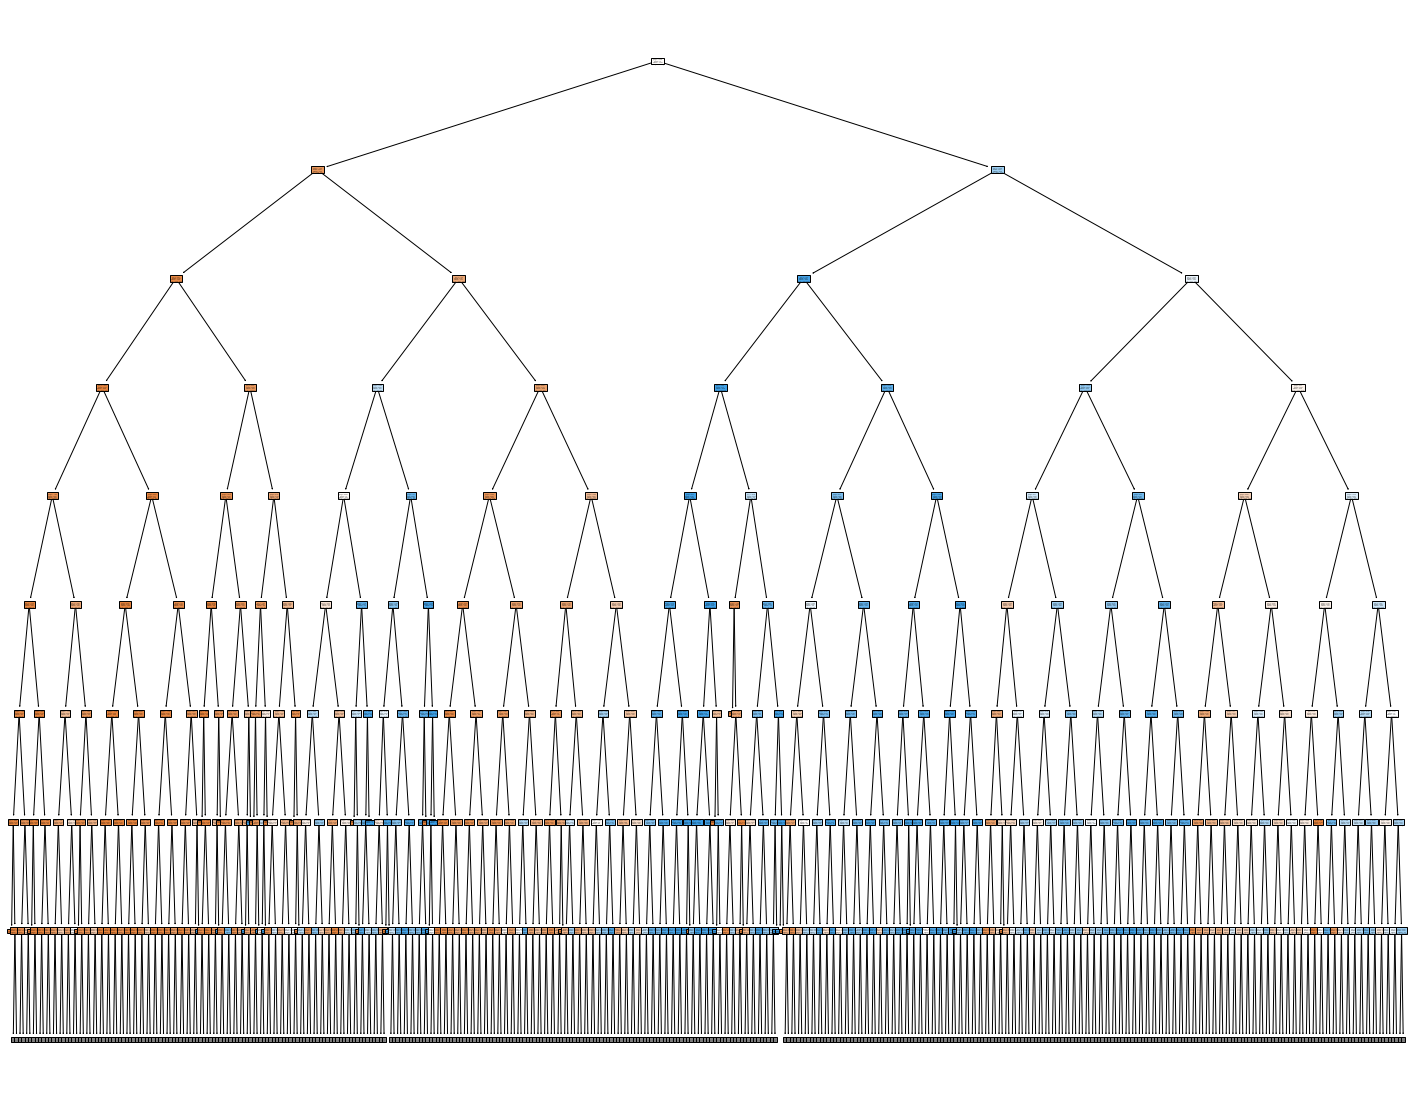

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dec_tree_clf, max_depth = 8, filled = True)
fig.savefig("decision_tree_non_pruned_depth_8.png")

**1.8: Prune the tree using one of the techniques discussed in class and evaluate the performance**

In [ ]:
# I will try and perform a post-pruning technique - Cost Complexity Prunning which is based on an alpha parameter
# Training the model and getting the range of alpha values and impurities
dec_tree_clf = DecisionTreeClassifier(criterion = "entropy", random_state = 2102)
dec_tree_clf.fit(X_dev_scaled, y_dev)

path = dec_tree_clf.cost_complexity_pruning_path(X_dev_scaled, y_dev)
print(f"The values of alpha and impurities are shown below:")
print(path)

print(f"The number of alpha values: {len(path['ccp_alphas'])}")
print(f"The numner of impurities' values: {len(path['impurities'])}")

The values of alpha and impurities are shown below:
{'ccp_alphas': array([0.00000000e+00, 1.22980181e-05, 1.22980181e-05, ...,
       1.72398417e-02, 9.64459831e-02, 1.82112769e-01]), 'impurities': array([0.00000000e+00, 2.45960361e-05, 4.91920723e-05, ...,
       7.21378660e-01, 8.17824643e-01, 9.99937412e-01])}
The number of alpha values: 8645
The numner of impurities' values: 8645


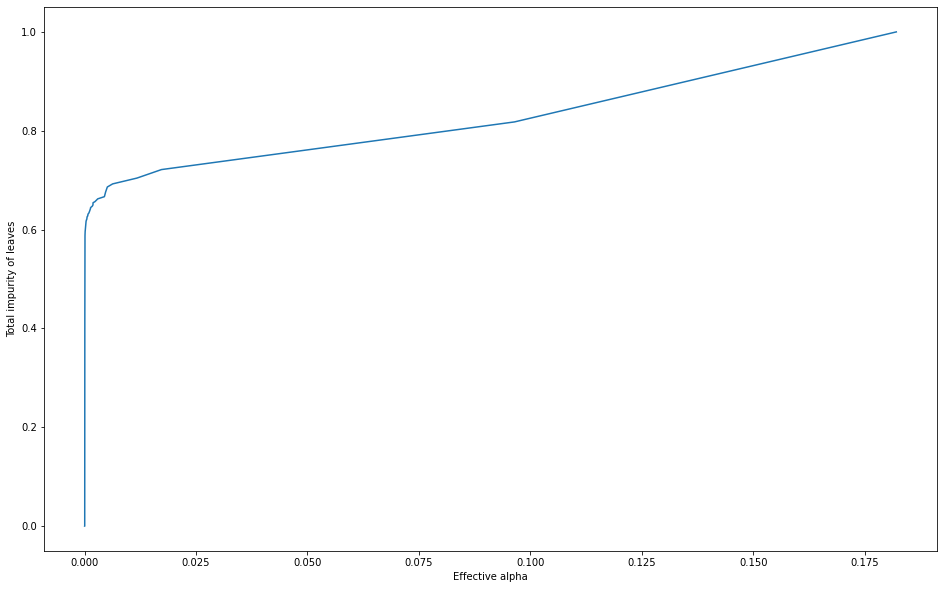

In [ ]:
# Let's visualize the relationship between alphas between impurities
fig = plt.figure(figsize=(16,10))
ccp_alphas, impurities = path.ccp_alphas, path.impurities
plt.plot(ccp_alphas, impurities)
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of leaves")
plt.show()

In [ ]:
# Now, we will find the optimal value of alpha (this will help us prune our tree)
# I will only be taking the last 100 alpha values into consideration due to the computational time
classifiers = []

for idx, ccp_alpha in enumerate(ccp_alphas[-101:-1]):
    print(f"At the {idx} : Running for Alpha Value: {ccp_alpha}")
    dec_tree_clf = DecisionTreeClassifier(criterion = "entropy", ccp_alpha = ccp_alpha, random_state = 2102)
    dec_tree_clf.fit(X_dev_scaled, y_dev)
    classifiers.append(dec_tree_clf)
    
print(f"Number of classifier trained: {len(classifiers)}")

At the 0 : Running for Alpha Value: 0.00018342773091504366
At the 1 : Running for Alpha Value: 0.00018343702898282986
At the 2 : Running for Alpha Value: 0.00018506338701328748
At the 3 : Running for Alpha Value: 0.00019095616456841005
At the 4 : Running for Alpha Value: 0.00019181838802418772
At the 5 : Running for Alpha Value: 0.00019425452384781022
At the 6 : Running for Alpha Value: 0.00019497083922229673
At the 7 : Running for Alpha Value: 0.00020136630968504293
At the 8 : Running for Alpha Value: 0.00020557010110616725
At the 9 : Running for Alpha Value: 0.0002146493782831803
At the 10 : Running for Alpha Value: 0.0002176327634655249
At the 11 : Running for Alpha Value: 0.00021925356541602214
At the 12 : Running for Alpha Value: 0.00022265058267974345
At the 13 : Running for Alpha Value: 0.00022303127246518263
At the 14 : Running for Alpha Value: 0.00022470008279738048
At the 15 : Running for Alpha Value: 0.0002272015026234149
At the 16 : Running for Alpha Value: 0.00022843458398

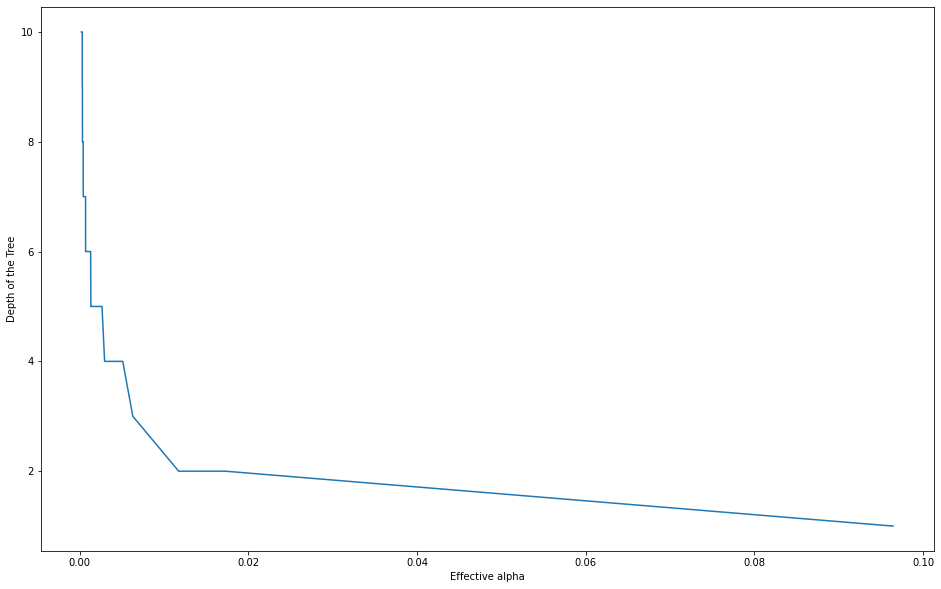

In [ ]:
# Finding relationship between tree depth and alpha
tree_depths = [classifier.tree_.max_depth for classifier in classifiers]
fig = plt.figure(figsize=(16,10))
plt.plot(ccp_alphas[-101:-1], tree_depths)
plt.xlabel("Effective alpha")
plt.ylabel("Depth of the Tree")
plt.show()

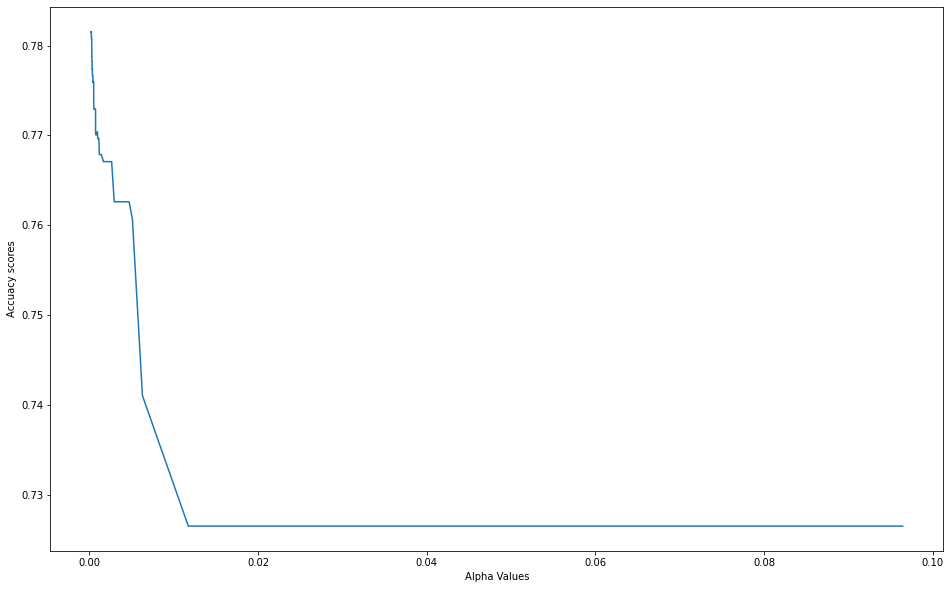

In [ ]:
# Finding relationship between alpha and accuracy
acc_scores = [accuracy_score(y_test, classifer.predict(X_test_scaled)) for classifer in classifiers]
fig = plt.figure(figsize=(16,10))
plt.plot(ccp_alphas[-101:-1], acc_scores)
plt.xlabel("Alpha Values")
plt.ylabel("Accuacy scores")
plt.show()

In [ ]:
# Now let's get the exact value of alpha at which we get the best accuracy
best_ccp_alpha = float("-inf")
best_max_depth = float("-inf")
highest_score = float("-inf")
for ccp_alpha, max_depth, score in zip(ccp_alphas[-101:-1], tree_depths, acc_scores):
    if score > highest_score:
        best_ccp_alpha = ccp_alpha
        best_max_depth = max_depth
        highest_score = score
        
print(f"I get the highest score {highest_score} at Max depth: {best_max_depth} and Alpha value: {best_ccp_alpha}")

I get the highest score 0.7815208503679477 at Max depth: 10 and Alpha value: 0.00019425452384781022


In [ ]:
# Now we will apply the optimal max depth and alpha 
# on the decision tree classifier in order to get the pruned tree.
dec_tree_clf_pruned = DecisionTreeClassifier(criterion = "entropy", \
                                             max_depth = best_max_depth, \
                                             ccp_alpha = best_ccp_alpha, \
                                             random_state = 2102)
dec_tree_clf_pruned.fit(X_dev_scaled, y_dev)

print(f"Score on Dev Data: {dec_tree_clf_pruned.score(X_dev_scaled, y_dev)}")
print(f"Score on Test Data: {dec_tree_clf_pruned.score(X_test_scaled, y_test)}")

Score on Dev Data: 0.7857001710310241
Score on Test Data: 0.7815208503679477


The performance of the model here (Decision Tree Classification) after pruning is better in comparison to when there were no restrictions on the maximum depth of the tree allowed and the value of alpha. Although the accuracy score on the development data might have decreased by a lot (from 100% to 78.5%) but the accuracy on the testing data has increased by more than 5% which shows that we were overfitting the data before. As overfitting the dataset is problematic, we want our model to be balanced w.r.t the specialization and the generalization. This is achieved well after we prune the tree in order to achieve the maximized accuracy score on the test data as well as the development dataset. 

**1.9: List the top 3 most important features for this trained tree? How would you justify these features being the most important?**

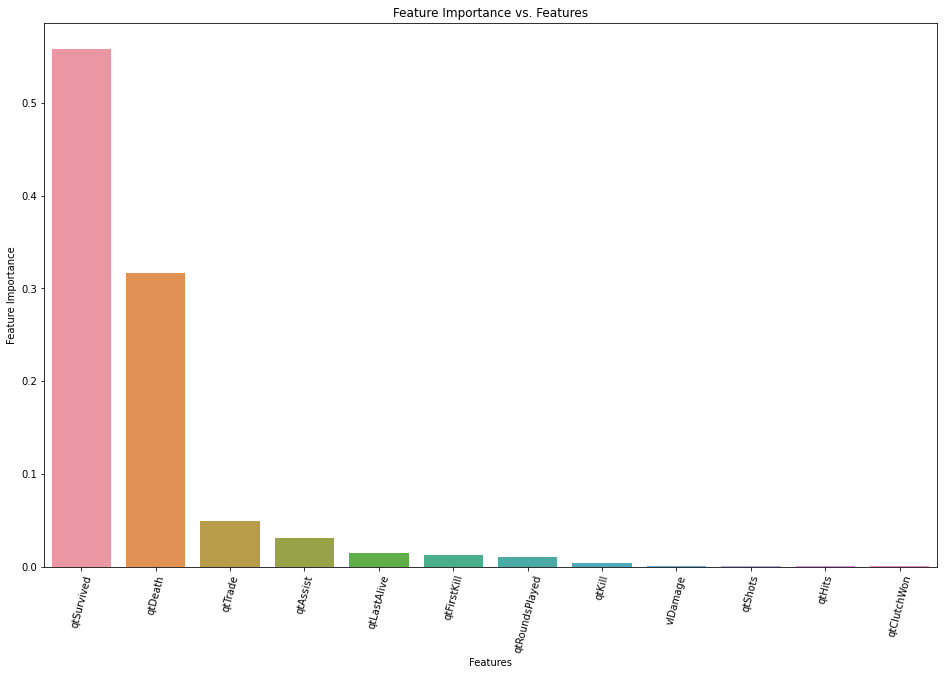

In [ ]:
import warnings
warnings.filterwarnings("ignore")

feature_names = list(X_dev_scaled.columns)
feature_importances = dec_tree_clf_pruned.feature_importances_
feature_importances_map = zip(feature_names, feature_importances)
sorted_feat_names, sorted_feat_importances = zip(*(sorted(list\
                                                    (filter(lambda x: x[1] != 0, feature_importances_map)),\
                                                    key = lambda x: x[1], reverse = True)))

fig = plt.figure(figsize=(16,10))
ax = sns.barplot(list(sorted_feat_names), list(sorted_feat_importances))
ax.set_xlabel("Features")
ax.set_ylabel("Feature Importance")
ax.set_title("Feature Importance vs. Features")
ax.tick_params(axis = 'x', rotation = 75)

The top 3 most important features are as follows as shown above:
1. qtSurvived
2. dtDeath
3. qtTrade

Reasons:
1. qtSurvived: As this feature signifies the number of survived rounds in the game, it is directly correlated with the probability that the game would be won or lost. As higher the number of survival, higher the probability of survivavbility in the game which would directly suggest the probability of winning the game and vice-versa, it makes complete logical sense for this feature being a highly important one for determing the winner of the game (flWinner: label of the dataset).
2. dtDeath: As this feature signifies the number of deaths in the game, it is directly related in determing the label or winner of the game under consideration. For instance, if the number of deaths are higher in a game, that would mean that the probability of winning would be less and vice-versa could be a correlation between the two. Thus, having this feature as a highly important one makes complete logical sense to me for determing the winner (label) of the game.
3. qtTrade: This feature signifies the number of trade kills in a game. This is a well-known strategy in combat games and is used a lot to win. This signifies the number of kills that a player makes on behalf of losing one of the teammates so, that the team can win the game. As this seems highly correlated in determining the winner of the game, it makes complete logical sense to me to have this feature as one of the most important features in our dataset in order to determine the label.

## Question 2: Random Forests

In [20]:
# Additional Imports for this section
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

**2.1: Train a Random Forest model on the development dataset using RandomForestClassifier class in sklearn. Use the default parameters. Evaluate the performance of the model on test dataset. Does this perform better than Decision Tree on the test dataset (compare to results in Q 1.6)?**

For Random Forest Classifier: 
Score on Dev Data: 0.9999931860149771
Score on Test Data: 0.7890160806759335


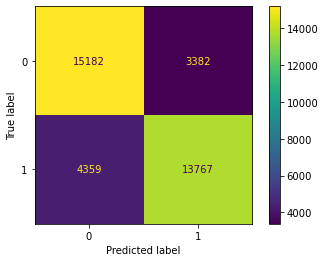

In [ ]:
random_forest_classifier = RandomForestClassifier(random_state = 2102)
random_forest_classifier.fit(X_dev_scaled, y_dev)

print("For Random Forest Classifier: ")
print(f"Score on Dev Data: {random_forest_classifier.score(X_dev_scaled, y_dev)}")
print(f"Score on Test Data: {random_forest_classifier.score(X_test_scaled, y_test)}")

plot_confusion_matrix(random_forest_classifier, X_test_scaled, y_test)

Performance Comparison:
Firstly, in comparison to the performance of the unpruned decision tree model, the random forest model performs quite well as the accuracy score on the test data is nearly 6% higher than the accuracy score of the decision tree model (in Q1.6). 
Secondly, the performance of the random forest classifier on the test dataset is quite good (78.9%). Also, by looking at the confusion matrix for the test dataset, we can say that the model performs quite well both in terms of true positives and true negatives. Although we can see that there is a huge number of false positives and false negatives for the trained random forest model, still it performs a lot better in comparison to the decision tree classifier. 

**2.2: Does all trees in the trained random forest model have pure leaves? How would you verify this?**

In [ ]:
total_num_leaves = 0
total_num_pure_leaves = 0
total_num_impure_leaves = 0

for estimator_idx, estimator in enumerate(random_forest_classifier.estimators_):
    num_leaves = 0
    num_pure_leaves = 0
    tree = estimator.tree_
    num_nodes = tree.node_count
    impurities = tree.impurity
    
    for node_idx in range(num_nodes):
        if tree.children_left[node_idx] != -1 or tree.children_right[node_idx] != -1:
            continue
        num_leaves += 1
        if impurities[node_idx] == 0:
            num_pure_leaves += 1
    
    num_impure_leaves = num_leaves - num_pure_leaves
    total_num_leaves += num_leaves
    total_num_pure_leaves += num_pure_leaves
    total_num_impure_leaves += num_impure_leaves
    
    print(f"For estimator {estimator_idx}:")
    print(f"#Leaves: {num_leaves}, #Pure Leaves: {num_pure_leaves}, #Impure Leaves: {num_impure_leaves}")
    
print("\n")
print(f"For all the estimators:")
print(f"#Leaves: {total_num_leaves}")
print(f"#Pure Leaves: {total_num_pure_leaves}, #Impure Leaves: {total_num_impure_leaves}")

For estimator 0:
#Leaves: 20785, #Pure Leaves: 20785, #Impure Leaves: 0
For estimator 1:
#Leaves: 20351, #Pure Leaves: 20351, #Impure Leaves: 0
For estimator 2:
#Leaves: 20423, #Pure Leaves: 20423, #Impure Leaves: 0
For estimator 3:
#Leaves: 19585, #Pure Leaves: 19585, #Impure Leaves: 0
For estimator 4:
#Leaves: 20147, #Pure Leaves: 20147, #Impure Leaves: 0
For estimator 5:
#Leaves: 20055, #Pure Leaves: 20055, #Impure Leaves: 0
For estimator 6:
#Leaves: 20279, #Pure Leaves: 20279, #Impure Leaves: 0
For estimator 7:
#Leaves: 20509, #Pure Leaves: 20509, #Impure Leaves: 0
For estimator 8:
#Leaves: 20393, #Pure Leaves: 20393, #Impure Leaves: 0
For estimator 9:
#Leaves: 20323, #Pure Leaves: 20323, #Impure Leaves: 0
For estimator 10:
#Leaves: 20064, #Pure Leaves: 20064, #Impure Leaves: 0
For estimator 11:
#Leaves: 21225, #Pure Leaves: 21225, #Impure Leaves: 0
For estimator 12:
#Leaves: 20446, #Pure Leaves: 20446, #Impure Leaves: 0
For estimator 13:
#Leaves: 20159, #Pure Leaves: 20159, #Impur

As shown above, we can see that all the trees in the trained random forest classifier model have pure leaves. There are no impure leaves to be found. Also, this verification was done by going over all the estimators (trees trained) in the random forest classifier model. And by then going over all the leaves and checking the impurity level of all those leaves, we find the count of the pure leaves and impure leaves for each of the trees formed. Conclusively, after going over all the trees, we find that no tree contained any impure leaves and thus, no tree had an impure leaf (all the leaves were pure).

**2.3: Assume you want to improve the performance of this model. Also, assume that you had to pick two hyperparameters that you could tune to improve its performance. Which hyperparameters would you choose and why?**


I would choose the hyperparameters "max_depth" and "n_estimators" to be tuned, to improve the performance of the model. This is mainly due to the following reasons:
1. max_depth: This hyperparameter signifies the maximum depth possible of the trees formed as a part of training the random forest classifier. Tuning this hyperparameter could restrict the number of features taken into consideration while forming the trees and thus, would prevent overfitting the development dataset. This, in turn, could result in a better performing model on the test dataset. It's known to be one of the most important hyperparemeters for the random forest classifier.
2. n_estimators: As the main difference between the decision tree classifier and random forest classifier is that we form many trees (a forest) while training a random forest classifier while just a single tree is formed in a decision tree classifier. Having more estimators would mean having more number of potential trees considering other restrictions placed on the model. As we have more number of trees in our model, it could mean well to cover the dataset in a more specialized manner. As different estimators (trees) could have different features under consideration with different importances, this would cover a lot more range of the labels in the dataset. Thus, I have decided to tune this hyperparameter as it signifies an intrinsic property behind the random forest classifier model and would make the model more comprehensive.

Additionally, I have used bootstrap and warm_start to be true as well but I won't be tuning them . This is because these parameters have been known to increase the performance of the random forest classifier model. While bootstrap let's us form different trees in a more comprehensive way by taking different sub-samples of the dataset into consideration, warm_start helps the model take some learnings from the previous trees formed and use those insights to form the next tree (would mean an incremental specialization of the model).

**2.4: Now, assume you had to choose up to 5 different values (each) for these two hyperparameters. How would you choose these values that could potentially give you a performance lift?**

I would choose the values as follows and the reason for choosing those values have been specified below:
1. max_depth: Values chosen: 5, 7, 9, 11, 13; As the number of features in our dataset is 40, we would like to have the max_depth value specified a little less in comparison to the number of features under consideration. As the pruned decision tree above had a max_depth of 10 and generally a good tree would have less depth, I am taking into consideration some values less than 10 and some values greater than 10 (on the lower end) for hyperparameter as these could be the potential fit for a performance lift.
2. n_estimators: Values chosen: 75, 100, 125, 150, 175; As the default value of the estimators is 100 which was used above to train the random forest classifier with default settings which gave us a decent performance lift in comparison to the decision tree classifier, I want this hyperparameter to be around that. As increasing the number of estimators would form more trees thus, increasing the chance of a performance lift, I have taken most of the values above 100 and just one value below the default value of 100 in order to be sure that having less number of trees won't be optimal. Also, if the number of estimators are very large, that has the potential to overfit the data so, I don't take very large values and thus, I take 3 values above 100 with increments of 25 estimators.

**2.5: Perform model selection using the chosen values for the hyperparameters. Use cross-validation for finding the optimal hyperparameters. Report on the optimal hyperparameters. Estimate the performance of the optimal model (model trained with optimal hyperparameters) on test dataset? Has the performance improved over your plain-vanilla random forest model trained in Q2.1?**

In [ ]:
param_grid = {
    "bootstrap": [True],
    "warm_start": [True],
    "max_depth": [5, 7, 9, 11, 13],
    "n_estimators": [75, 100, 125, 150, 175]
}

pipe = make_pipeline(GridSearchCV(RandomForestClassifier(oob_score = True, random_state = 2102), \
                                  param_grid = param_grid, \
                                  cv = 5,
                                  return_train_score = True, \
                                  verbose = 2))
pipe.fit(X_dev_scaled, y_dev)

grid_search_results = pipe.named_steps["gridsearchcv"]
grid_search_result_max_depth = grid_search_results.best_params_['max_depth']
grid_search_result_n_estimators = grid_search_results.best_params_['n_estimators']

print(f"Best value of hyperparameter max_depth is: {grid_search_result_max_depth}")
print(f"Best value of hyperparameter n_estimators is: {grid_search_result_n_estimators}")
print(f"Best Accuracy Score: {grid_search_results.best_score_}")
print(f"Accuracy Score for Testing Data: {pipe.score(X_test_scaled, y_test) * 100}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END bootstrap=True, max_depth=5, n_estimators=75, warm_start=True; total time=  12.0s
[CV] END bootstrap=True, max_depth=5, n_estimators=75, warm_start=True; total time=   6.9s
[CV] END bootstrap=True, max_depth=5, n_estimators=75, warm_start=True; total time=   6.7s
[CV] END bootstrap=True, max_depth=5, n_estimators=75, warm_start=True; total time=   6.6s
[CV] END bootstrap=True, max_depth=5, n_estimators=75, warm_start=True; total time=   8.2s
[CV] END bootstrap=True, max_depth=5, n_estimators=100, warm_start=True; total time=  14.1s
[CV] END bootstrap=True, max_depth=5, n_estimators=100, warm_start=True; total time=   8.9s
[CV] END bootstrap=True, max_depth=5, n_estimators=100, warm_start=True; total time=  12.1s
[CV] END bootstrap=True, max_depth=5, n_estimators=100, warm_start=True; total time=  14.2s
[CV] END bootstrap=True, max_depth=5, n_estimators=100, warm_start=True; total time=  12.6s
[CV] END bootstrap=True

In [ ]:
random_forest_tuned_clf = RandomForestClassifier(oob_score = True, bootstrap = True, \
                                           warm_start = True, max_depth = 13, \
                                           n_estimators = 150,random_state = 2102)
random_forest_tuned_clf.fit(X_dev_scaled, y_dev)

print(f"Accuracy Score for Dev Data: {random_forest_tuned_clf.score(X_dev_scaled, y_dev) * 100}")
print(f"Accuracy Score for Testing Data: {random_forest_tuned_clf.score(X_test_scaled, y_test) * 100}")

Accuracy Score for Dev Data: 84.63514517195091
Accuracy Score for Testing Data: 78.98064867811392


The optimal hyperparameters found are as follows:
1. max_depth: 13
2. n_estimators: 150

As we can see above, the accuracy score on the testing data for the tuned random forest classifier has increased but very marginally. Although, as the score on the development data has decreased signifying that we are not overfitting the data now and the trained model should now be generalized rather than overfitting the data. I would say that in general the performance of the model has increased but not by much. 

**2.6: Can you find the top 3 most important features from the model trained in Q2.5? How do these features compare to the important features that you found from Q1.9? If they differ, which feature set makes more sense?**

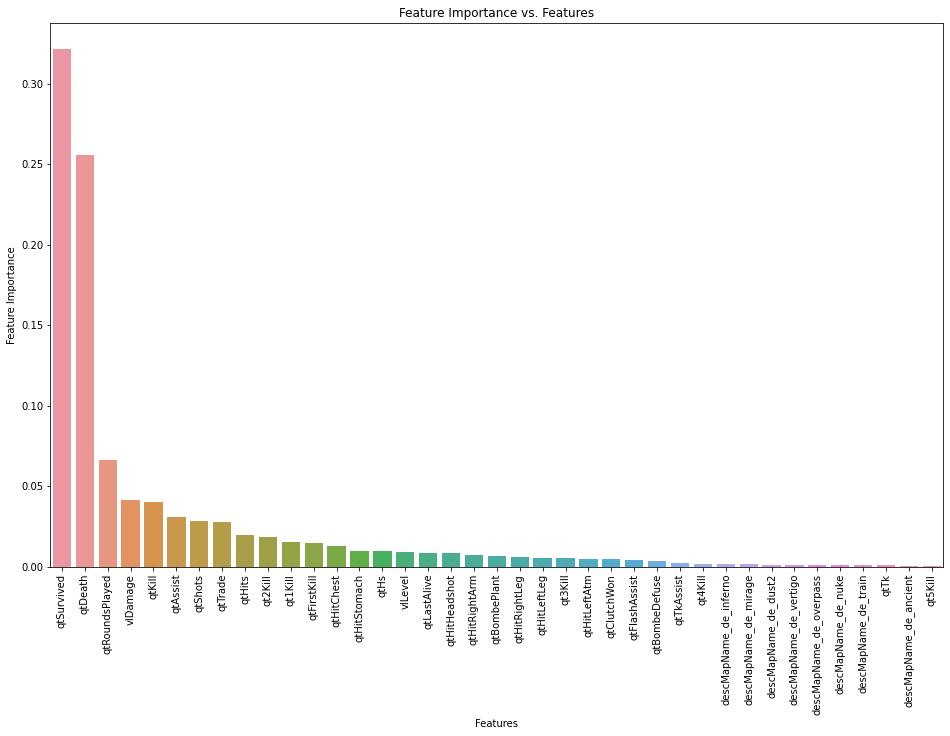

In [ ]:
import warnings
warnings.filterwarnings("ignore")

feature_names = list(X_dev_scaled.columns)
feature_importances = random_forest_tuned_clf.feature_importances_
feature_importances_map = zip(feature_names, feature_importances)
sorted_feat_names, sorted_feat_importances = zip(*(sorted(list\
                                                    (filter(lambda x: x[1] != 0, feature_importances_map)),\
                                                    key = lambda x: x[1], reverse = True)))

fig = plt.figure(figsize=(16,10))
ax = sns.barplot(list(sorted_feat_names), list(sorted_feat_importances))
ax.set_xlabel("Features")
ax.set_ylabel("Feature Importance")
ax.set_title("Feature Importance vs. Features")
ax.tick_params(axis = 'x', rotation = 90)

The top 3 most important features from the trained random forest (tuned) classifier model above are as follows:
1. qtSurvived
2. qtDeath
3. qtRoundsPlayed

As we can see, the top 2 most important features match with that of the decision tree classifier but the third one differs. For the decision tree classifier, the third most important feature was "qtTrade" instead of the "qtRoundsPlayed" feature for the random forest classifier model. Furthermore, the feature set for the decision tree classifier makes more sense than that of the random forest classifier. This is mainly because making a trade kill is a very well known technique in the gaming community that is used to make fast kills and thus, win the game. This feature signifying the number of trade kills is thus, heavily tied with the game and thus, should be very helpful in determining the winner of the game. On the other hand, rounds played cannot be directly tied with the winner of the game. Some might argue that higher the number of rounds played, greater the probability of winning but that can't always be true and doesn't seem to be more tied with target variable than the number of trade kills.

## Question 3: Gradient Boosted Trees

In [21]:
# Additional Imports for this section
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
import time

**3.1: Choose three hyperparameters to tune GradientBoostingClassifier and HistGradientBoostingClassifier on the development dataset using 5-fold cross validation. Report on the time taken to do model selection for both the models. Also, report the performance of the test dataset from the optimal models.**

In [ ]:
# Gradient Boosting Classifier

# Setting the grid for hyperparameter tuning for GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [7, 10, 13],
    'n_estimators': [100, 125, 150]
}

pipe = make_pipeline(GridSearchCV(GradientBoostingClassifier(random_state = 2102), \
                                  param_grid = param_grid, \
                                  cv = 5,
                                  return_train_score = True, \
                                  verbose = 2))

print("For Gradient Boosting Classifier:")
begin_time = time.time()
pipe.fit(X_dev_scaled, y_dev)
end_time = time.time()
print(f"Total time taken for model selection and training the model is: {(end_time - begin_time)/60} minutes.")

grid_search_results = pipe.named_steps["gridsearchcv"]
grid_search_result_lr = grid_search_results.best_params_['learning_rate']
grid_search_result_max_depth = grid_search_results.best_params_['max_depth']
grid_search_result_n_estimators = grid_search_results.best_params_['n_estimators']

print(f"Best value of hyperparameter learning_rate is: {grid_search_result_lr}")
print(f"Best value of hyperparameter max_depth is: {grid_search_result_max_depth}")
print(f"Best value of hyperparameter n_estimators is: {grid_search_result_n_estimators}")
print(f"Best Accuracy Score: {grid_search_results.best_score_}")
print(f"Accuracy Score for Testing Data: {pipe.score(X_test_scaled, y_test) * 100}")

For Gradient Boosting Classifier:
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 1.5min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 1.5min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 1.5min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 1.5min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 1.4min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=125; total time= 1.8min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=125; total time= 1.8min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=125; total time= 1.8min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=125; total time= 1.8min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=125; total time= 1.8min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=150; total time= 2.1min
[CV] END ...l

In [ ]:
# Time Analysis for Gradient Boosting
print(f"Average Time Taken across all the 135 fits using Gradient Boosting Classifier: {394.04562026262283/135} minutes!")

Average Time Taken across all the 135 fits using Gradient Boosting Classifier: 2.918856446389799 minutes!


In [ ]:
# Hist Gradient Boosting Classifier

# Setting the grid for hyperparameter tuning for GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0001],
    'max_depth': [5, 7, 9, 11, 13],
    'l2_regularization': [0, 0.1, 0.01, 0.001, 0.0001]
}

pipe = make_pipeline(GridSearchCV(HistGradientBoostingClassifier(random_state = 2102), \
                                  param_grid = param_grid, \
                                  cv = 5,
                                  return_train_score = True, \
                                  verbose = 2))

print("For Hist Gradient Boosting Classifier:")
begin_time = time.time()
pipe.fit(X_dev_scaled, y_dev)
end_time = time.time()
print(f"Total time taken for model selection and training the model is: {(end_time - begin_time)/60} minutes.")

grid_search_results = pipe.named_steps["gridsearchcv"]
grid_search_result_lr = grid_search_results.best_params_['learning_rate']
grid_search_result_max_depth = grid_search_results.best_params_['max_depth']
grid_search_result_l2_regs = grid_search_results.best_params_['l2_regularization']

print(f"Best value of hyperparameter learning_rate is: {grid_search_result_lr}")
print(f"Best value of hyperparameter max_depth is: {grid_search_result_max_depth}")
print(f"Best value of hyperparameter l2_regularization is: {grid_search_result_l2_regs}")
print(f"Best Accuracy Score: {grid_search_results.best_score_}")
print(f"Accuracy Score for Testing Data: {pipe.score(X_test_scaled, y_test) * 100}")

For Hist Gradient Boosting Classifier:
Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV] END l2_regularization=0, learning_rate=0.1, max_depth=5; total time=   7.1s
[CV] END l2_regularization=0, learning_rate=0.1, max_depth=5; total time=   4.6s
[CV] END l2_regularization=0, learning_rate=0.1, max_depth=5; total time=   4.7s
[CV] END l2_regularization=0, learning_rate=0.1, max_depth=5; total time=   4.5s
[CV] END l2_regularization=0, learning_rate=0.1, max_depth=5; total time=   4.5s
[CV] END l2_regularization=0, learning_rate=0.1, max_depth=7; total time=   5.1s
[CV] END l2_regularization=0, learning_rate=0.1, max_depth=7; total time=   5.0s
[CV] END l2_regularization=0, learning_rate=0.1, max_depth=7; total time=   5.1s
[CV] END l2_regularization=0, learning_rate=0.1, max_depth=7; total time=   5.0s
[CV] END l2_regularization=0, learning_rate=0.1, max_depth=7; total time=   5.0s
[CV] END l2_regularization=0, learning_rate=0.1, max_depth=9; total time=   5.2s
[CV] EN

In [ ]:
# Time Analysis for Hist Gradient Boosting
print(f"Average Time Taken across all the 625 fits using Hist Gradient Boosting Classifier: {66.7500392238299/625} minutes!")

Average Time Taken across all the 625 fits using Hist Gradient Boosting Classifier: 0.10680006275812784 minutes!


Summarizing the results for the two models above:
1. Gradient Boosting: Total Time Taken for model selection: 394.045 minutes. Accuracy score on Test dataset: 80.18%. The performance of this model has improved from the random forest classifier.
2. Hist Gradient Boosting: Total Time Taken for model selection: 66.75 minutes. Accuracy score on Test dataset: 80.03%. The performance of this model has improved from the random forest classifier.

**3.2: Train an XGBoost model by tuning 3 hyperparameters using 5 fold cross-validation. Compare the performance of the trained XGBoost model on the test dataset against the performances obtained from 3.1**

In [ ]:
# XGB Classifier

# Setting the grid for hyperparameter tuning for GridSearchCV
param_grid = {
    'eta': [0.001, 0.01, 0.1],
    'max_depth': [5, 7, 10],
    'gamma': [0, 3, 7]
}

pipe = make_pipeline(GridSearchCV(XGBClassifier(random_state = 2102), \
                                  param_grid = param_grid, \
                                  cv = 5,
                                  return_train_score = True, \
                                  verbose = 2))

print("For XGB Classifier:")
begin_time = time.time()
pipe.fit(X_dev_scaled, y_dev)
end_time = time.time()
print(f"Total time taken for model selection and training the model is: {(end_time - begin_time)/60} minutes.")

grid_search_results = pipe.named_steps["gridsearchcv"]
grid_search_result_lr = grid_search_results.best_params_['eta']
grid_search_result_max_depth = grid_search_results.best_params_['max_depth']
grid_search_result_gamma = grid_search_results.best_params_['gamma']

print(f"Best value of hyperparameter eta is: {grid_search_result_lr}")
print(f"Best value of hyperparameter max_depth is: {grid_search_result_max_depth}")
print(f"Best value of hyperparameter gamma is: {grid_search_result_gamma}")
print(f"Best Accuracy Score: {grid_search_results.best_score_}")
print(f"Accuracy Score for Testing Data: {pipe.score(X_test_scaled, y_test) * 100}")

For XGB Classifier:
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....................eta=0.001, gamma=0, max_depth=5; total time=  22.8s
[CV] END ....................eta=0.001, gamma=0, max_depth=5; total time=  23.3s
[CV] END ....................eta=0.001, gamma=0, max_depth=5; total time=  23.1s
[CV] END ....................eta=0.001, gamma=0, max_depth=5; total time=  23.4s
[CV] END ....................eta=0.001, gamma=0, max_depth=5; total time=  22.7s
[CV] END ....................eta=0.001, gamma=0, max_depth=7; total time=  35.3s
[CV] END ....................eta=0.001, gamma=0, max_depth=7; total time=  35.6s
[CV] END ....................eta=0.001, gamma=0, max_depth=7; total time=  36.1s
[CV] END ....................eta=0.001, gamma=0, max_depth=7; total time=  42.3s
[CV] END ....................eta=0.001, gamma=0, max_depth=7; total time=  35.4s
[CV] END ...................eta=0.001, gamma=0, max_depth=10; total time= 1.0min
[CV] END ..................

In [ ]:
# Time Analysis for XG Boost Classifier
print(f"Average Time Taken across all the 135 fits using XG Boost Classifier: {90.82600705623626/135} minutes!")

Average Time Taken across all the 135 fits using XG Boost Classifier: 0.672785237453602 minutes!


In [ ]:
# Creating XGBoost model with the best hyperparameters found above 
xgb_clf = XGBClassifier(eta = 0.001, max_depth = 7, gamma = 7, random_state = 2102)
xgb_clf.fit(X_dev_scaled, y_dev)

print(f"Accuracy Score for Dev Data: {xgb_clf.score(X_dev_scaled, y_dev) * 100}")
print(f"Accuracy Score for Testing Data: {xgb_clf.score(X_test_scaled, y_test) * 100}")

Accuracy Score for Dev Data: 81.67855707053155
Accuracy Score for Testing Data: 80.48787135459253


The performance of the XG Boost Classifier with the best hyperparameters found from the Grid Search above is found to be little better than the Gradient Boosting Classifier and Hist Gradient Boosting Classifier. This is based on the fact that the accuracy score on the test dataset found with the XG Boost Classifier is 80.49% while with the Gradient Boosting it was 80.18% and with the Hist Gradient Boosting, it was 80.03%. Although the difference is not much as XG Boost performs marginally better than the Gradient Boosting and Hist Gradient Boosting models.

**3.3: Compare the results on the test dataset from XGBoost, HistGradientBoostingClassifier, GradientBoostingClassifier with results from Q1.6 and Q2.1. Which model tends to perform the best and which one does the worst? How big is the difference between the two? Which model would you choose among these 5 models and why?**

For all the values below, the performance is measured in terms of the accuracy score:
1. Decision Tree Classifier: 73.03%
2. Tuned Decision Tree Classifier: 78.15%
3. Random Forest Classifier: 78.9%
4. Tuned Random Forest Classifier: 78.98%
5. Gradient Boosting Classifier: 80.18%
6. Hist Gradient Boosting Classifier: 80.03%
7. XG Boost Classifier: 80.49%

The model that tends to perform the best is the XG Boost Classifier and the model that seems to perform the worst is the Decision Tree Classifier. The performance difference (Accuracy score difference) for these two models is quite large (if not huge) with an improve in performance of 80.49 - 73.03 = 7.46%. 

I would choose the XG Boost Classifier because of the following reasons:
1. As the XG Boost Classifier performs the best according to the accuracy score among all the 5 models trained, I will choose this model. Although the performance difference between the Gradient Boosting, Hist Gradient Boosting and XG Boost Classifier is quite less, still, XG Boost performs the best among these three.
2. As time taken by the Gradient Boosting Classifier is huge in comparison to the Hist Gradient Boosting and XG Boost Classifier, I wouldn't take that model as I have another model that fits the data even better (albeit marginally). Also, Hist Gradient Boosting Classifier takes the least time so, I could have chosen that but as the XG Boost performs marginally better and has GPU support as well, I would consider XG Boost as my model going forward for this classification task.

**3.4: Can you list the top 3 features from the trained XGBoost model? How do they differ from the features found from Random Forest and Decision Tree? Which one would you trust the most?**

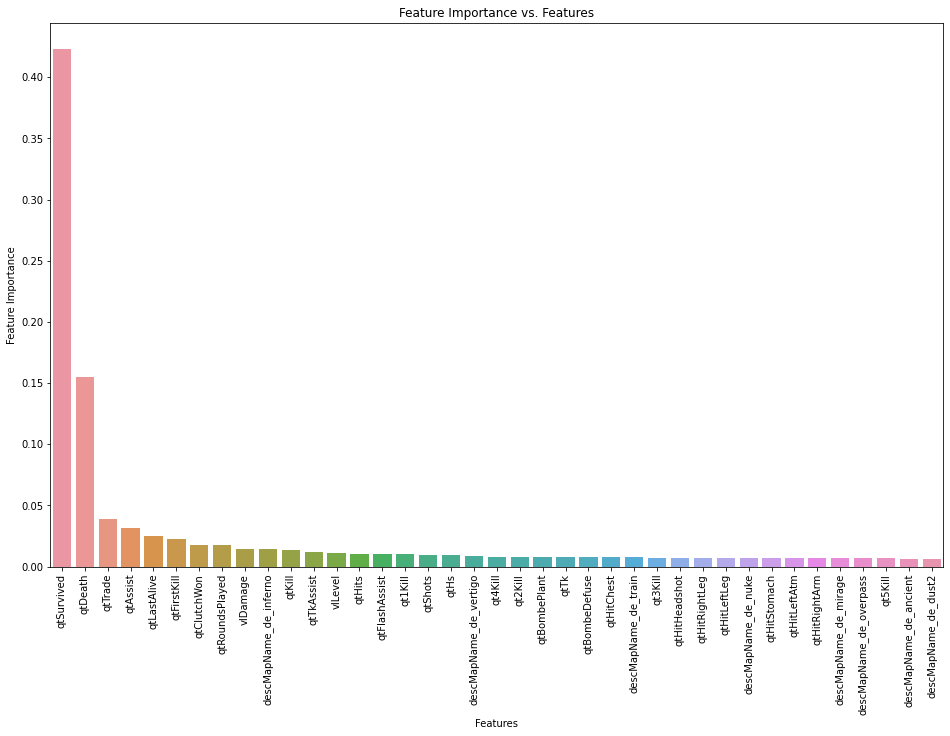

In [ ]:
import warnings
warnings.filterwarnings("ignore")

feature_names = list(X_dev_scaled.columns)
feature_importances = xgb_clf.feature_importances_
feature_importances_map = zip(feature_names, feature_importances)
sorted_feat_names, sorted_feat_importances = zip(*(sorted(list\
                                                    (filter(lambda x: x[1] != 0, feature_importances_map)),\
                                                    key = lambda x: x[1], reverse = True)))

fig = plt.figure(figsize = (16,10))
ax = sns.barplot(list(sorted_feat_names), list(sorted_feat_importances))
ax.set_xlabel("Features")
ax.set_ylabel("Feature Importance")
ax.set_title("Feature Importance vs. Features")
ax.tick_params(axis = 'x', rotation = 90)

The top 3 features for the tuned XG Boost Classifier is as follows:
1. qtSurvived
2. qtDeath
3. qtTrade

This is the same 3 most important features as that of the Decision Tree Classifier but the third one differs from the Random Forest Classifier (qtRoundsPlayed instead of qtTrade). I would trust the feature set from Decision Tree Classifier and XG Boost as the better one. This is primarly because of the fact that qtTrade is a known strategy for winning the combat games and is found to be quite useful for winning the game if the players are efficient with it. So, this serves as a better correlation feature in comparison to some arbitrary number of rounds played. Some might argue that more the number of rounds played, higher the probability of winning, but that is not always the case and we don't know that for sure. In comparison to that, the number of trade kills ties up with the game data pretty well and is a known technique. Thus, I would choose the current feature set as the best one. 

**3.5: Can you choose the top 7 features (as given by feature importances from XGBoost) and repeat Q3.2? Does this model perform better than the one trained in Q3.2? Why or why not is the performance better?**

In [ ]:
top_7_features = list(sorted_feat_names[:7])
print(f"We will consider the following features for training now: {top_7_features}")

# Setting the grid for hyperparameter tuning for GridSearchCV
param_grid = {
    'eta': [0.001, 0.01, 0.1],
    'max_depth': [5, 7, 10],
    'gamma': [0, 3, 7]
}

pipe = make_pipeline(GridSearchCV(XGBClassifier(random_state = 2102), \
                                  param_grid = param_grid, \
                                  cv = 5,
                                  return_train_score = True, \
                                  verbose = 2))

print("For XGB Classifier:")
begin_time = time.time()
pipe.fit(X_dev_scaled[top_7_features], y_dev)
end_time = time.time()
print(f"Total time taken for model selection and training the model is: {(end_time - begin_time)/60} minutes.")

grid_search_results = pipe.named_steps["gridsearchcv"]
grid_search_result_lr = grid_search_results.best_params_['eta']
grid_search_result_max_depth = grid_search_results.best_params_['max_depth']
grid_search_result_gamma = grid_search_results.best_params_['gamma']

print(f"Best value of hyperparameter eta is: {grid_search_result_lr}")
print(f"Best value of hyperparameter max_depth is: {grid_search_result_max_depth}")
print(f"Best value of hyperparameter gamma is: {grid_search_result_gamma}")
print(f"Best Accuracy Score: {grid_search_results.best_score_}")
print(f"Accuracy Score for Testing Data: {pipe.score(X_test_scaled[top_7_features], y_test) * 100}")

We will consider the following features for training now: ['qtSurvived', 'qtDeath', 'qtTrade', 'qtAssist', 'qtLastAlive', 'qtFirstKill', 'qtClutchWon']
For XGB Classifier:
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....................eta=0.001, gamma=0, max_depth=5; total time=  10.3s
[CV] END ....................eta=0.001, gamma=0, max_depth=5; total time=   9.6s
[CV] END ....................eta=0.001, gamma=0, max_depth=5; total time=   8.0s
[CV] END ....................eta=0.001, gamma=0, max_depth=5; total time=   8.0s
[CV] END ....................eta=0.001, gamma=0, max_depth=5; total time=   8.0s
[CV] END ....................eta=0.001, gamma=0, max_depth=7; total time=  11.5s
[CV] END ....................eta=0.001, gamma=0, max_depth=7; total time=  11.5s
[CV] END ....................eta=0.001, gamma=0, max_depth=7; total time=  11.5s
[CV] END ....................eta=0.001, gamma=0, max_depth=7; total time=  11.6s
[CV] END ....................eta=0.00

This model performs marginally worse than the one trained in Q3.2 part of this section. Although the difference is quite less but still it performs marginally worse. This could be attributed to the fact that we have removed some features from the dataset that had some impact on the accuracy. Although those features might not have been very important but still had some say in determining the winner of the game. Maybe taking 10 most important features would resolve this! We have to be very careful in throwing away the data when it's needed to not to impact the performance of the model. This case here shows that quite reasonably.

## Question 4: Calibration

In [22]:
# Additional imports for this section
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import plot_confusion_matrix

**4.1: Estimate the brier score for the XGBoost model (trained with optimal hyperparameters from Q3.2) scored on the test dataset.**

In [25]:
import warnings
warnings.filterwarnings("ignore")

xgb_clf = XGBClassifier(eta = 0.001, max_depth = 7, gamma = 7, random_state = 2102)
xgb_clf.fit(X_dev_scaled, y_dev)
pred_probs = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print(f"Brier Score for Optimal XGBoost Classifier: {brier_score_loss(y_test, pred_probs)}")

[15:20:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Brier Score for Optimal XGBoost Classifier: 0.23014719060239275


**4.2: Calibrate the trained XGBoost model using isotonic regression as well as Platt scaling. Plot predicted v.s. actual on test datasets from both the calibration methods**

In [26]:
# Splitting the data first
X_train, X_calib, y_train, y_calib = train_test_split(X_dev_scaled, y_dev, test_size = 0.2, random_state = 2102)

[15:21:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


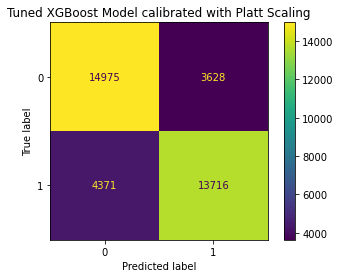

In [27]:
xgb_clf = XGBClassifier(eta = 0.001, max_depth = 7, gamma = 7, random_state = 2102)
xgb_clf.fit(X_train, y_train)

xgb_platt_calib = CalibratedClassifierCV(xgb_clf, cv = "prefit", method = "sigmoid")
xgb_platt_calib.fit(X_calib, y_calib)

plot_confusion_matrix(xgb_platt_calib, X_test_scaled, y_test)
plt.title("Tuned XGBoost Model calibrated with Platt Scaling")
plt.show()

[15:21:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


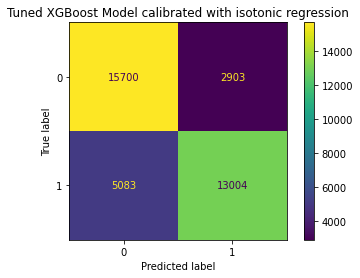

In [28]:
xgb_isotonic_calib = CalibratedClassifierCV(xgb_clf, cv = "prefit", method = "isotonic")
xgb_isotonic_calib.fit(X_calib, y_calib)

plot_confusion_matrix(xgb_isotonic_calib, X_test_scaled, y_test)
plt.title("Tuned XGBoost Model calibrated with isotonic regression")
plt.show()

**4.3: Report brier scores from both the calibration methods. Do the calibration methods help in having better predicted probabilities?**

In [29]:
pred_probs_xgb_platt = xgb_platt_calib.predict_proba(X_test_scaled)[:, 1]
pred_probs_xgb_isotonic = xgb_isotonic_calib.predict_proba(X_test_scaled)[:, 1]

print("Brier Score for Tuned XG Boost Model with Platt Scaling : ", \
      brier_score_loss(y_test, pred_probs_xgb_platt))
print("Brier Score for Tuned XG Boost Model with Isotonic Regression : ", \
      brier_score_loss(y_test, pred_probs_xgb_isotonic))

Brier Score for Tuned XG Boost Model with Platt Scaling :  0.14257674148862304
Brier Score for Tuned XG Boost Model with Isotonic Regression :  0.14051463766800043


As the Brier Scores for the XG Boost Models with calibration methods is quite less in comparison to the original XG Boost Model, we can say that for sure the calibration methods help in having better prediction probabilities. 

<h2><center> END OF ASSIGNMENT </center></h2>